In [1]:

import sys, os
sys.path.append("C:\Users\Miguel\Desktop\Working_Space\pygeomod\pygeomod")
import geoPyMC
import pymc as pm
import numpy as np
import geogrid
import matplotlib.pyplot as plt
reload (geoPyMC)
from itertools import chain
%matplotlib inline


In [2]:
pm.half_cauchy_like?

In [3]:
import pynoddy
pynoddy.compute_model?

In [4]:
ori_grav = np.loadtxt(r"C:\Users\Miguel\Desktop\Working_Space\Sandstone_project\temp\Sandstone_geophys\Sst_grav_500.xyz")
#ori_grav_grid = ori_grav[:,3].reshape((resolution[1],resolution[0]))


In [6]:
ori_grav.shape

(10625L, 4L)

In [4]:
reload(geogrid)
reload(geoPyMC)
GeoBay = geoPyMC.GeoPyMC_sim("Sandstone")
GeoBay.proj_dir("C:\\Users\\Miguel\\Desktop\\Working_Space\\Sandstone_project\\Temp_SandstoneCopy")
#GeoBay.temp_creation("C:\Users\Miguel\Desktop\Temp_SandstoneCopy", )

In [5]:
GeoBay.read_excel("parameters.xlsx", verbose = 0)

In [6]:
# Creates a PyMC object corresponding to a normal distribution of every parameter provided 


# Now we GeoBay has the PyMC instances contact_points_mc, dips_mc and azimuths_mc encapsulating our uncertainty/priors
#print GeoBay.contact_points_mc#, GeoBay.dips_mc, GeoBay.azimuths_mc

Gravity Contour plot


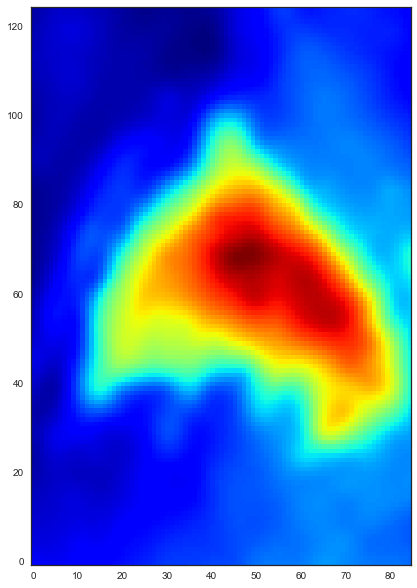

In [7]:
GeoBay.original_grav("temp\Sandstone_geophys\Sst_grav_500.xyz"
                     , type = "xyz", resolution= [85,125], verbose = 2)
#a = plt.colorbar()
#a.set_label("[mgal]")
#plt.savefig("Gravity colorbar.pdf")

In [8]:
GeoBay.set_Stoch_normal_distribution()

In [9]:
"""
#===============================
# First Constrains: Input data
#=============================

@pm.deterministic
def aux_det(contact_points_mc = GeoBay.contact_points_mc):
    # =====
    # Order of layers

    SM2_Atley = GeoBay.contact_points_mc[[int(np.argwhere(GeoBay.data_depth[:,0]=="simple_mafic_Atley_left")),
                                         int(np.argwhere(GeoBay.data_depth[:,0]=="simple_mafic_Atley_centre")),
                                         int(np.argwhere(GeoBay.data_depth[:,0]=="simple_mafic_Atley_right")),
                                        ]]

    BIF_Atley = GeoBay.contact_points_mc[[int(np.argwhere(GeoBay.data_depth[:,0]=="BIF_Atley_3")),
                                          int(np.argwhere(GeoBay.data_depth[:,0]=="BIF_Atley_4")),
                                          int(np.argwhere(GeoBay.data_depth[:,0]=="BIF_Atley_5"))]]
    Atley_dif_1 = SM2_Atley - BIF_Atley
    order_layers_det = 0
    for dif in Atley_dif_1:
        dif = dif.value
       # print dif
        if dif < 0:
            try:
                counter_OL += 1      
            except UnboundLocalError:
                counter_OL = 0
           # print " I am in b"
            order_layers_det +=-1


    #=============
    # two_folds
    counter = 0
    #print SM2_Atley[1] < SM2_Atley[0], SM2_Atley[1].value, SM2_Atley[0].value
    if SM2_Atley[1].value < SM2_Atley[0].value and SM2_Atley[1].value < SM2_Atley[2].value:
        #print "I am here: two folds1"
        counter -= 1
    if BIF_Atley[1].value < BIF_Atley[0].value and BIF_Atley[1].value < BIF_Atley[2].value:
        counter -= 1
        #print "I am here: two folds2"
    #print "counter: ", counter

    return order_layers_det, counter

@pm.stochastic
def order_layers_l(value = -1, prob_o = aux_det[0]):
 #   print "order of layers: ",prob_o
    return prob_o

@pm.stochastic
def two_folds_l(value = -1, prob_t = aux_det[1]):
 #   print "two folds: ",prob_t
    return prob_t  


"""
# ===============================================================================
# Generation of model
# ===============================================================================

#================= Creating the GeoModel ===================
#============================================================

# In our Bayesian Network the GeoModel behaves as a deterministic function
@pm.deterministic(trace= True)
def model(contact_points_val_mc = GeoBay.contact_points_mc, azimuths_val = GeoBay.azimuths_mc , dips_val = GeoBay.dips_mc,
       ):
    return  GeoBay.deterministic_GeoModel("Temp_SandstoneCopy.xml",resolution=[85,125,51],geomod_coord = False,
                                          noddy_geophy= True, densities=  { 1: 2.61,
                                                                           2: 2.61,
                                                                           3: 2.92,
                                                                           4: 3.1,
                                                                           5: 2.92,
                                                                           6: 2.61

                                                                           }, verbose = 0, two_points = False,
                                         plot_direction = "y", plot_cell = 50, z_dim = [-20000,200], calc_range =0,
                                         extent = [696000,747000,
                                                   6863000,  6950000])


#dif = np.append(dif,np.sum(abs(min_max_scaler.fit_transform(model.value.geophys.grv_data)
#                                   -aux)))
#aux = model.value.geophys.grv_data
#time = np.append(time,a.best)
#    print np.shape(model.value.geophys.grv_data), np.shape(forw_gravs)

#    forw_gravs = np.dstack((forw_gravs, model.value.geophys.grv_data))


#=================================
# Inversion
#=================================

@pm.deterministic
def e_sq(value = GeoBay.ori_grav_grid,model = model, verbose = 0):
   
    Forw = model.geophys.grv_data[:-50,18:,]
    #print np.median(value),np.median(Forw)
    # shifting
   # shift = np.median(-value)-np.median(Forw)
    shift = -450-np.median(Forw)#np.median(value)-np.median(Forw)
    #Forw = X_train_minmax = min_max_scaler.fit_transform(Forw, feature_range=(0, 10))
    
    
 
    # Calibration parameters
    F_min, F_max =  np.min(Forw), np.max(Forw)   #36.630742, 36.651496    #30.159309, 30.174104#
    F_range = F_max - F_min
    F_mid = 0.5*(F_max+F_min)

    rs_min, rs_max = np.min(value), np.max(value)
    rs_range = rs_max - rs_min
    rs_mid = 0.5*(rs_max+rs_min)

    #Rescaling

   # rs_mid + (grid - m_mid) / m_range * rs_range
    Reescaled_forw = rs_mid + (Forw - F_mid) / F_range * rs_range
    if verbose > 0:
        plt.imshow(model.geophys.grv_data[:,:,], origin= "lower_left", cmap="jet")
        plt.show()
        plt.imshow(value, origin= "lower_left", cmap="jet")
        plt.colorbar()
        plt.show()
        plt.hist(value.ravel())
        plt.show()
        plt.imshow(Reescaled_forw, origin= "lower_left", cmap="jet")
        plt.show()
        plt.imshow(Forw, origin= "lower_left", cmap="jet")
        plt.colorbar()
        plt.show()
        plt.hist(Reescaled_forw.ravel())
        plt.show()

    
    e_sq = np.sqrt(np.sum((Reescaled_forw - (value))**2))
    #print np.min(Reescaled_forw), np.max(Reescaled_forw)
    print e_sq
    return e_sq

"""


@pm.observed
def inversion(value = 1, e_sq = e_sq):
    return pm.half_cauchy_like(e_sq,0,10000.)


@pm.stochastic
def layer2_conti_l(value = 1, model = model):

    n_columns = 0
    model_2 = np.ones_like(model.grid) * (model.grid == 2)
    vertical_sum_2 = np.sum(model_2, axis = 2)
    vertical_sum_lt0 = np.ones_like(vertical_sum_2) * (vertical_sum_2 > 0)
    ny, nx = vertical_sum_lt0.shape
    for i in range(30,70):
        line = vertical_sum_lt0[i,:]
        switchpoints = np.sum(np.abs(line[:-1] - line[1:]))
        if switchpoints > 2:
            n_columns += 1
    meters_discont = n_columns * model.dely[0]
    if n_columns == 0:
       # print "layer2_conti: 0"
        return 0
    else:
       # print "layer2_conti: ", np.log10(0.5 - 0.01*meters_discont/500)
       # print "===============next model =============="
        return np.log10(0.5 - 0.01*meters_discont/500)
"""
#===========================================================
#===========================================================
#CREATING THE MODEL
#==========================================================
#=========================================================
# Chaining the arrays
parameters = list(chain(GeoBay.contact_points_mc
                        ,GeoBay.dips_mc,
                         GeoBay.azimuths_mc))




GeoBay.creating_Bayes_model([#aux_det,
                             #order_layers_l, two_folds_l,
                             #   e_sq,inversion, 
                              #  layer2_conti_l,
                               model], verbose = 0)


C:\Anaconda2\lib\site-packages\pymc\Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


8349.05872776


In [ ]:
S = pm.MCMC(GeoBay.pymc_model,db= "hdf5" , dbname= "database_temp/27thJulnothing2.hdf5" )
S.restore_sampler_state()
S.sample(iter = 45, burn = 0)




In [ ]:
%%javascript
IPython.notebook.kernel.restart();
                 $(IPython.events).one('kernel_ready.Kernel',
                                       function(){IPython.notebook.execute_all_cells();});


In [ ]:
plt.plot(dif, "o")
plt.title("Sum of difference between calc_range+1 and calc_range")
#plt.plot([result.best for result in time] , "o")
plt.title("Time needed")
display.clear_output(wait=True)
display.display(plt.gcf())
plt.close()
    
display.clear_output(wait=True)

In [ ]:
for i in range(21):
    print "min,max calc_range ", str(i), " ", np.min(forw_gravs[::-1,:,i][:-5,:]),np.max(forw_gravs[::-1,:,i][:-5,:])
    print "quantile", np.percentile(forw_gravs[::-1,:,i][:-5,:], 75) -np.percentile(forw_gravs[::-1,:,i][:-5,:], 25)
    print "quantile2", np.percentile(forw_gravs[::-1,:,i][:-5,:], 95) -np.percentile(forw_gravs[::-1,:,i][:-5,:], 5)
    print "median", np.median(forw_gravs[::-1,:,i][:-5,:])
    print "range ",np.min(forw_gravs[::-1,:,i][:-5,:])-np.max(forw_gravs[::-1,:,i][:-5,:])
    print ""
    

In [ ]:
np.max(min_max_scaler.fit_transform(forw_gravs[::-1,:,4][:-5,:]))

In [ ]:
cbar.5

In [ ]:
plt.ion()
import IPython.display as display

for i in range(1,21):
    
  
    plotted =  plt.imshow((forw_gravs[::-1,:,i][:-5,:]), cmap="jet")
    cbar = plt.colorbar(mappable=plotted,  )
    plt.title("Forward gravity spatial: Calc Range = "+ str(i-1))

    plt.savefig(r"C:\Users\Miguel\Desktop\Working_Space\Sandstone_project\Plots\Forward gravities\Calc_Range = "+ str(i-1)+".pdf")
    plt.draw()

    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.close()
display.clear_output(wait=True)

In [ ]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.transform?

In [ ]:
X_train_minmax = min_max_scaler.transform

In [ ]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(forw_gravs[::-1,:,i+1][:-5,:])
print X_train_minmax
np.min(normalize(forw_gravs[::-1,:,i+1][:-5,:],norm='l1'), )

In [ ]:
dif = []
for i in range(20):
    dif = np.append(dif,np.sum(abs(min_max_scaler.fit_transform(forw_gravs[::-1,:,i+1][:-5,:])
                                   -min_max_scaler.fit_transform(forw_gravs[::-1,:,i][:-5,:]))))
plt.plot(dif, "o")
plt.title("Sum of difference between calc_range+1 and calc_range")

In [ ]:
S = pm.MCMC(GeoBay.pymc_model );
S.sample(iter =300);

In [ ]:
import pynoddy as nd
# Inverted spatial 20, high two res
range_12_same_extent = nd.output.NoddyGeophysics("geogrid")
print np.shape(range_12_same_extent.grv_data),np.min(range_12_same_extent.grv_data), np.max(range_12_same_extent.grv_data) 
plt.imshow(range_12_same_extent.grv_data, origin = "lower left",
                interpolation = 'nearest', cmap = 'jet')# ,vmin = 108.61)
plt.colorbar()

In [ ]:
plt.imshow(np.pad(a, ((12,12),(12,12),(0,0)), "reflect")[:,:,-10])

In [ ]:
import pynoddy as nd
# Inverted spatial 20, high two res
range_12_same_extent = nd.output.NoddyGeophysics("geogrid")
print range_12_same_extent.grv_data,np.min(range_12_same_extent.grv_data), np.max(range_12_same_extent.grv_data) 
plt.contourf(range_12_same_extent.grv_data, 20,  cmap = 'jet')
#, origin = "lower left",
 #               interpolation = 'nearest', cmap = 'jet')# ,vmin = 108.61)
plt.colorbar()
print np.shape(range_12_same_extent.grv_data)

In [ ]:
import pynoddy as nd
# Inverted spatial 20, high two res
range_12_same_extent = nd.output.NoddyGeophysics("geogrid")
print range_12_same_extent.grv_data,np.min(range_12_same_extent.grv_data), np.max(range_12_same_extent.grv_data), np.shape(range_12_same_extent.grv_data) 
plt.imshow(range_12_same_extent.grv_data, origin = "lower left",
                interpolation = 'nearest', cmap = 'jet')# ,vmin = 108.61)
plt.colorbar()

In [ ]:
plt.contourf?

In [ ]:
import pynoddy as nd
# Inverted spatial 20, high two res
range_12_same_extent = nd.output.NoddyGeophysics("geogrid")
print range_12_same_extent.grv_data,np.min(range_12_same_extent.grv_data), np.max(range_12_same_extent.grv_data) 
plt.contourf(range_12_same_extent.grv_data, 80,  cmap = 'jet')
#, origin = "lower left",
 #               interpolation = 'nearest', cmap = 'jet')# ,vmin = 108.61)
plt.colorbar()

In [ ]:
import pynoddy as nd
# Inverted spatial 20, high two res
range_12_same_extent = nd.output.NoddyGeophysics("geogrid")
print range_12_same_extent.grv_data,np.min(range_12_same_extent.grv_data), np.max(range_12_same_extent.grv_data) 
plt.imshow(range_12_same_extent.grv_data, origin = "lower left",
                interpolation = 'nearest', cmap = 'jet')# ,vmin = 108.61)
plt.colorbar()

In [ ]:
# Inverted all
range_12_same_extent = nd.output.NoddyGeophysics("geogrid")
print range_12_same_extent.grv_data,np.min(range_12_same_extent.grv_data), np.max(range_12_same_extent.grv_data) 
plt.imshow(range_12_same_extent.grv_data, origin = "lower left",
                interpolation = 'nearest', cmap = 'jet')# ,vmin = 108.61)
plt.colorbar()

In [ ]:
import pynoddy as nd

In [ ]:
# INVERTED SPECTRAL

range_12_same_extent = nd.output.NoddyGeophysics("geogrid")
print range_12_same_extent.grv_data,np.min(range_12_same_extent.grv_data), np.max(range_12_same_extent.grv_data) 
plt.imshow(range_12_same_extent.grv_data, origin = "lower left",
                interpolation = 'nearest', cmap = 'jet')# ,vmin = 108.61)
plt.colorbar()

In [ ]:
# non INVERTED SPECTRAL
range_12_same_extent = nd.output.NoddyGeophysics("geogrid")
print range_12_same_extent.grv_data,np.min(range_12_same_extent.grv_data), np.max(range_12_same_extent.grv_data) 
plt.imshow(range_12_same_extent.grv_data, origin = "lower left",
                interpolation = 'nearest', cmap = 'jet')# ,vmin = 108.61)
plt.colorbar()
#plt.savefig("Spatial_range1.png")

In [ ]:
import pynoddy as nd

### This is Geophysical calculation 2, range 12, with the same cube size 100 (almost certain)

In [ ]:
range_12_same_extent = nd.output.NoddyGeophysics("geogrid")
print range_12_same_extent.grv_data
plt.imshow(range_12_same_extent.grv_data, origin = "lower left",
                interpolation = 'nearest', cmap = 'viridis')

### This should be geophysical calculation 2, range 0, with cell size 240 or so

The values range were around 5

In [ ]:
plt.imshow(model.value.geophys.grv_data, origin = "lower left",
                interpolation = 'nearest', cmap = 'viridis')
plt.colorbar()

print model.value.geophys.grv_data

### This is geophysical calculations 2, range 12, cell size 240

the values range were in 250

In [ ]:
range_12_geophys_calc_2 = nd.output.NoddyGeophysics("geogrid")
print range_12_geophys_calc_2.grv_data
plt.imshow(range_12_geophys_calc_2 .grv_data, origin = "lower left",
                interpolation = 'nearest', cmap = 'viridis')

### This is the substraction of the last two

In [ ]:
plt.imshow(range_twelve.grv_data - range_0.grv_data[12:-12,12:-12], origin = "lower left",
                interpolation = 'nearest', cmap = 'viridis')

## Geophysical calculation 0, calculation range 0, cell sizes 255

In [ ]:
plt.imshow(model.value.geophys.grv_data, origin = "lower left",
                interpolation = 'nearest', cmap = 'viridis')
plt.colorbar()

print model.value.geophys.grv_data

## Geophysical calculation 0, calculation range 12, cell sizes 255

In [ ]:
range_12_geophys_calc_0 = nd.output.NoddyGeophysics("geogrid")
print range_12_geophys_calc_0.grv_data
plt.imshow(range_12_geophys_calc_0 .grv_data, origin = "lower left",
                interpolation = 'nearest', cmap = 'viridis')

### Geophysical calculation 1, range 0, cell size 255

In [ ]:
plt.imshow(model.value.geophys.grv_data, origin = "lower left",
                interpolation = 'nearest', cmap = 'viridis')
plt.colorbar()

print model.value.geophys.grv_data

### Geophysical calculation 1, range 12, cell size 255

In [ ]:
range_12_geophys_calc_1= nd.output.NoddyGeophysics("geogrid")
print range_12_geophys_calc_1.grv_data
plt.imshow(range_12_geophys_calc_1 .grv_data, origin = "lower left",
                interpolation = 'nearest', cmap = 'viridis')

In [ ]:
plt.scatter(range_0.grv_data[12:-12,12:-12].ravel(), range_twelve.grv_data.ravel())
pol= np.polyfit(range_0.grv_data[12:-12,12:-12].ravel(), range_twelve.grv_data.ravel(), 1)
print pol
plt.plot(pol)
plt.xlabel("range 0")
plt.ylabel("range 12")

In [ ]:
S = pm.MCMC(GeoBay.pymc_model,db= "hdf5" , dbname= "database_temp/5thFeb.hdf5" )
S.restore_sampler_state()
S.sample(iter =45)

In [ ]:
S.db.close()

In [ ]:
%%javascript
IPython.notebook.kernel.restart();
                 $(IPython.events).one('kernel_ready.Kernel',
                                       function(){IPython.notebook.execute_all_cells();});


In [ ]:
def plot_two_and_diff(grid1, grid2, filename = "grid.png"):
    objf = obj_func(grid1, grid2)
    fig = plt.figure(figsize = (14,5))
    ax1 = fig.add_subplot(131)
    im1 = ax1.imshow(grid1, interpolation = "None", cmap = 'viridis', origin = 'lower_left')
    plt.colorbar(im1)
    ax2 = fig.add_subplot(132)
    im2 = ax2.imshow(grid2, interpolation = "None", cmap = 'viridis', origin = 'lower_left')
    plt.colorbar(im2) 
    #plt.title("Model, real, and difference; model: %s; obj.f: %.2f" % (key,objf) )
    ax3 = fig.add_subplot(133)
    im2 = ax3.imshow(grid2-grid1, interpolation = "None", cmap = 'RdBu', origin = 'lower_left')
    plt.colorbar(im2)
    if not filename == "":
        plt.savefig(filename)
        
def obj_func(grid, real):
    return np.sqrt(np.sum(grid - real)**2)


#====================================================
#=========================
Forw = model.value.geophys.grv_data
value = GeoBay.ori_grav_grid

print np.max(Forw), np.min(Forw)
# Calibration parameters
F_min, F_max = 30.159309, 30.174104# np.min(Forw), np.max(Forw)   #36.630742, 36.651496    #30.159309, 30.174104#
F_range = F_max - F_min
F_mid = 0.5*(F_max+F_min)

rs_min, rs_max = np.min(value+1000), np.max(value+1000)
rs_range = rs_max - rs_min
rs_mid = 0.5*(rs_max+rs_min)
print rs_range, rs_mid,  rs_max, rs_min
print F_range, F_mid,
#Rescaling

#rs_mid + (grid - m_mid) / m_range * rs_range
Reescaled_forw = rs_mid + (Forw - F_mid) / F_range * rs_range





plot_two_and_diff(GeoBay.ori_grav_grid+1000, Reescaled_forw)

In [ ]:
import pymc as pm

In [ ]:
#b = pm.HalfCauchy(i/0.3,1,40) 

a = [pm.half_cauchy_like(i/0.5,1,5E3) for i in np.linspace(1,50E3, 200)]
plt.plot(  np.linspace(1,50E3, 200), a)

In [ ]:
 print np.max(model.geophys.grv_data), np.min(model.geophys.grv_data)
    Forw = model.geophys.grv_data
   # pickle.dump(Forw, open( "bad.p", "wb" ) )
    Forw_norm = (Forw-np.min(Forw))/(np.max(Forw)-np.min(Forw))
    value_norm = (value-np.min(value))/(np.max(value)-np.min(value))
    e_sq = np.sum(np.square(value_norm - Forw_norm))
    
   # print np.gradient(value_norm), np.gradient(Forw_norm)
    e_sq3 = (np.sum(np.square(np.gradient(value_norm)[0] - np.gradient(Forw_norm)[0])) + 
            np.sum(np.square(np.gradient(value_norm)[1] - np.gradient(Forw_norm)[1])))
   
    # Alternative
    m_max, m_min = np.max(value), np.min(value)
    n_max, n_min = 72.421121, 72.295415
    
    static_shift = m_min + n_min
    #static_shift = (m_min+m_max)/2 + (n_max+n_min)/2
    scaling = (n_max - n_min)/(- m_min + m_max) 
   # print (+ m_max - m_min)
   # print static_shift, scaling
    e_sq2 =  np.sqrt(np.sum(np.square(value - ((Forw - n_min) * scaling + static_shift))))
    
    
   # print e_sq,"%e"  %e_sq2, e_sq3

In [ ]:
model.value.extent_y/model.value.ny

In [ ]:
model.value.dely

In [ ]:
model_2 = np.ones_like(model.value.grid) * (model.value.grid == 2)

In [ ]:
plt.imshow(model_2[:,30,:].transpose(), origin ='lower left', interpolation = 'None')

In [ ]:
vertical_sum_2 = np.sum(model_2, axis = 2)

In [ ]:
plt.imshow(vertical_sum_2.transpose(), interpolation = 'None', origin = 'lower left')

In [ ]:
vertical_sum_lt0 = np.ones_like(vertical_sum_2) * (vertical_sum_2 > 0)

In [ ]:
vertical_sum_lt0.shape

In [ ]:
plt.imshow(vertical_sum_lt0.transpose(), interpolation = 'None', origin = 'lower left')

In [ ]:
ny, nx = vertical_sum_lt0.shape
for i in range(30,70):
    line = vertical_sum_lt0[i,:]
    switchpoints = np.sum(np.abs(line[:-1] - line[1:]))
    if switchpoints > 2:
        print("HOLE!!!!!")

## Export priors

In [ ]:
GeoBay.set_priors()
GeoBay.export_priors_p()

In [ ]:
S.sample(iter = 40, )

In [ ]:

a = [ 10**pm.half_cauchy_like(i,0,10000.) for i in np.linspace(0,20000,1000)]
plt.plot( np.linspace(0,20000,1000), a )

## Posterior models

In [ ]:
reload(geoPyMC)

In [ ]:
reload(geoPyMC)
GeoPost = geoPyMC.GeoPyMC_GeoMod_from_posterior("5thFeb.hdf5",
                                                forbbiden = ["adaptive","model","deviance", "likelihood", "e_sq", "constrain",
        "Metropolis","layer2_conti", "order_layers", "SM2_Atley", "two_folds", "inversion", "layer2_conti" ] )

GeoPost.proj_dir("C:\\Users\\Miguel\\Desktop\\Working_Space\\Sandstone_project\\Temp_SandstoneCopy")

In [ ]:
GeoPost.recover_parameters()
GeoPost.original_grav("temp\Sandstone_geophys\Sst_grav_500.xyz"
                     , type = "xyz", resolution= [85,125], verbose = 0)

In [ ]:
@pm.deterministic(trace= True)
def model(contact_points_val_mc = GeoPost.contact_points_mc, azimuths_val = GeoPost.azimuths_mc , dips_val = GeoPost.dips_mc):
    return  GeoPost.deterministic_GeoModel("Temp_SandstoneCopy.xml",resolution=[85,125,50],
                                          noddy_geophy= True, densities=  {1: 2.61,
                                                                           2: 2.92,
                                                                           3: 3.1,
                                                                           4: 2.92,
                                                                           5: 2.61}, verbose = 1, two_points = False,
                                         plot_direction = "x", plot_cell = 40, z_dim = [-20000,1000],) #extent = [
                                                                                                     #         730100, 730300,
                                                                                                      #         6893900,6894100])
print model.value[model.value>0]
GeoPost.creating_Bayes_model([model], verbose = 0)

In [ ]:
extent = [ 705000.0 ,747000.0, 6863000.0, 6925000.0]

In [ ]:

P = pm.MCMC(GeoPost.pymc_model,  db= "hdf5" , dbname= "database_temp/1Dentropy2.hdf5")

In [ ]:
P.sample(iter = 2000)